In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import math
from unet import UNet
from RFDN import RFDN
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook, trange, tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from dynamic import LongitudinalDynamicGeneration
from scipy.constants import m_p, c, e
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau

/home/genuser/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


PyHEADTAIL v1.16.5


In [2]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    

In [3]:
params_dataset = {}
params_dataset['V'] = [[90e3, 100e3]]
params_dataset['len_dataset'] = 512
params_dataset['sigma_z'] = [10/5, 10/2] #границы для sigma_z
params_dataset['sigma_p'] = [0.001, 0.0016]
params_dataset['max_z'] = [2, 12]
params_dataset['max_p'] = [1e-5, 1e-3]
params_dataset['c_z_u'] = [0, 9] #параметр для равноменого
params_dataset['c_z_n'] = [0, 6] #параметр для нормального 
params_dataset['c_p'] = [0, 7e-4]
params_dataset['alpha'] = 0.5
params_dataset['macroparticlenumber'] = 2000
params_dataset['N_turns'] = 1000
params_dataset['N_input'] = 128
params_dataset['N_output'] = 128                                                                             

In [4]:
p0 = 1.4e9 * e/c
gamma  = np.sqrt(1 + (p0/(m_p*c))**2)
beta = np.sqrt(1-1/gamma**2)
dp = 0. * e/p0 * 1./(beta*c) #* normalisation
params = {}
params['len']= 504
params['phi'] = [np.pi]
params['V'] = [80e3]
params['h'] = [22]
params['gamma'] = np.sqrt(1 + (p0/(m_p*c))**2)
params['charge'] = e
params['mass'] = m_p
params['alpha'] = 0.027 
params['p_increment'] = 0 #? dp*p0
params['intensity'] = 1e10
params['sc'] = 1.05

In [5]:
class CustomDataset(Dataset):
    def __init__(self, params, params_gen):
        
        self.__len_dataset__ = params['len_dataset']
        self.sigma_z = params['sigma_z']
        self.sigma_p = params['sigma_p']
        self.max_z = params['max_z']
        self.max_p = params['max_p']
        self.c_z_u = params['c_z_u']
        self.c_z_n = params['c_z_n']
        self.c_p = params['c_p']
        self.macroparticlenumber = params['macroparticlenumber']
        self.N_turns = params['N_turns']
        self.N_input = params['N_input']
        self.N_output = params['N_output']
        self.V = params['V']
        self.generator = LongitudinalDynamicGeneration(params_gen)
        
    def beam_initialization(self, alpha, sigma_z, sigma_p, max_z, max_p, c_z_u, c_z_n, c_p):

        self.generator.beam_init(sigma_z, sigma_p, max_z, max_p, c_z_u, c_z_n, c_p, alpha, self.macroparticlenumber)
        
    def __len__(self):
        return self.__len_dataset__

    def __getitem__(self, idx):

        V = []
        for i in range(len(self.V)):
        
            V.append(self.V[i][0] + np.random.random()*(self.V[i][1]-self.V[i][0]))
        self.generator.RF_init(V)
        # для равномерного 
        stop = False
        while not stop:
            max_z = self.max_z[0]+np.random.random()*(self.max_z[1]-self.max_z[0])
            c_z_u = self.c_z_u[0]+np.random.random()*(self.c_z_u[1]-self.c_z_u[0])
            if c_z_u <= -0.7*max_z + 10.4 and max_z <= -10/7*c_z_u +14.85:
                stop = True
                
        # для нормального 
        stop = False 
        while not stop:
            sigma_z = self.sigma_z[0]+np.random.random()*(self.sigma_z[1]-self.sigma_z[0])
            c_z_n = self.c_z_n[0]+np.random.random()*(self.c_z_n[1]-self.c_z_n[0])
            if c_z_n <= -sigma_z + 8 and sigma_z <= -1*c_z_n + 8:
                stop = True
            
        sigma_p = self.sigma_p[0]+np.random.random()*(self.sigma_p[1]-self.sigma_p[0])
        
        max_p = self.max_p[0]+np.random.random()*(self.max_p[1]-self.max_p[0])
        c_p = self.c_p[0]+np.random.random()*(self.c_p[1]-self.c_p[0])
        alpha = np.random.rand()
        self.beam_initialization(alpha, sigma_z, sigma_p, max_z, max_p, c_z_u, c_z_n, c_p)
        z, dp, _, _ = self.generator.dynamic(self.N_turns)
        plt.scatter(z[0], dp[0])
        gists, I = self.generator.data_preparation(self.N_turns, self.N_input, self.N_output, z, dp)
        gists = gists[None,:,:]
        I = I[None,:,:]
        return gists.astype(np.float32), I.astype(np.float32)

In [6]:
params_model = {}
params_model['in_nc'] = 1
params_model['nf'] = 100
params_model['num_modules'] = 4
params_model['out_nc'] = 1
params_model['upscale'] = 1
params_training = {}
params_training['device'] = 'cuda:0'
params_training['flag_load_model'] = False
params_training['name_for_save'] = 'model_rfdn.pt'
params_training['name_log_loss'] = 'log_loss_tr'

In [7]:
class Training():
    def __init__(self, params_model, params_training):
        self.device = params_training['device']
        self.flag_load_model = params_training['flag_load_model']
        self.name_for_save = params_training['name_for_save']
        self.name_log_loss = params_training['name_log_loss']
        self.model = RFDN(params_model = params_model) 
        if self.flag_load_model:
            self.model.load_state_dict(torch.load(self.name_for_save, map_location = 'cpu'))
        self.model.to(self.device)
        self.loss_function = nn.MSELoss()
        self.epoch = 0
        try:
            os.remove(self.name_log_loss)
        except: 
            pass
        
    def fit(self, train_loader, epochs,  optimizer):
   
        self.model.train()
        
        for epoch in range(epochs):
            self.epoch += 1 
            loss_val = 0 
            nmse_val = 0
            k = 0
            for x_input , x_output in tqdm(train_loader, desc='Training', position=0, leave=True):
                x_input = x_input.to(self.device)
                x_output = x_output.to(self.device)
                
                prediction = self.model(x_input)
                
                loss  = self.loss_function(prediction, x_output)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_val = loss_val + loss.item()
                k = k + 1
                if np.isnan(loss_val):
                    break
            loss_val = loss_val / k
            print('epoch = ' + str(epoch) +  '  loss = ' + str(np.round(loss_val, 4)) )

            self.log_loss(loss_val)
            
            if scheduler is not None:
                scheduler.step(loss_val)
            
            if np.isnan(loss_val) == False:
                # узнать правильно это или нет
                #current_date = datetime.now().strftime('%Y-%m-%d')
                if self.epoch % 100 == 0 and self.epoch!= 0:
                    save_path = f"{self.name_for_save}_{self.epoch}.pt"
                    torch.save(self.model.state_dict(), save_path)

    def result(self, train_data_loader):
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
        input_, output_ = next(iter(train_data_loader))
        output_ = output_.cpu().numpy()
        with torch.no_grad():
            pred = self.model(input_.to(self.device))
            pred = pred.detach().cpu().numpy()
        
        input_ = input_.cpu().numpy()
        axes[0].imshow(input_[0,0].squeeze())
        axes[0].axis("off")
        axes[0].set_title(f"Входные данные")
            
        
        axes[1].imshow(pred[0,0].squeeze())
        axes[1].axis("off")
        axes[1].set_title(f"Нейросеть")
            
        
        axes[2].imshow(output_[0,0].squeeze())
        axes[2].axis("off")
        axes[2].set_title(f"Генератор")
        
        plt.tight_layout()
        plt.show()
        
        
    def log_loss(self, loss_val):
        with open(self.name_log_loss, "a") as file:
            file.write(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Loss: {loss_val}\n")


In [8]:
class Training_U():
    def __init__(self, params_model, params_training):
        self.device = params_training['device']
        self.flag_load_model = params_training['flag_load_model']
        self.name_for_save = params_training['name_for_save']
        self.name_log_loss = params_training['name_log_loss']
        self.model = UNet(in_channels=1, out_channels=1)
        if self.flag_load_model:
            self.model.load_state_dict(torch.load(self.name_for_save, map_location = 'cpu'))
        self.model.to(self.device)
        self.loss_function = nn.MSELoss()
        self.epoch = 0
        try:
            os.remove(self.name_log_loss)
        except: 
            pass
        
    def fit(self, train_loader, epochs,  optimizer):
   
        self.model.train()
        
        for epoch in range(epochs):
            self.epoch += 1 
            loss_val = 0 
            nmse_val = 0
            k = 0
            for x_input , x_output in tqdm(train_loader, desc='Training', position=0, leave=True):
                x_input = x_input.to(self.device)
                x_output = x_output.to(self.device)
                
                prediction = self.model(x_input)
                
                loss  = self.loss_function(prediction, x_output)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_val = loss_val + loss.item()
                k = k + 1
                if np.isnan(loss_val):
                    break
            loss_val = loss_val / k
            print('epoch = ' + str(epoch) +  '  loss = ' + str(np.round(loss_val, 4)) )

            self.log_loss(loss_val)
            
            if np.isnan(loss_val) == False:
                # узнать правильно это или нет
                #current_date = datetime.now().strftime('%Y-%m-%d')
                if self.epoch % 50 == 0 and self.epoch!= 0:
                    save_path = f"{self.name_for_save}_{self.epoch}.pt"
                    torch.save(self.model.state_dict(), save_path)

    def train_one_epoch(self, train_loader, optimizer):
        self.model.train()
        loss_val = 0
        k = 0

        for x_input , x_output in tqdm(train_loader, desc=f'Epoch {self.epoch}', position=0, leave=True):
            x_input = x_input.to(self.device)
            x_output = x_output.to(self.device)

            prediction = self.model(x_input)
            loss = self.loss_function(prediction, x_output)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_val += loss.item()
            k += 1

        loss_val /= k
        print(f'Epoch {self.epoch} | Loss: {loss_val:.6f}')
        self.log_loss(loss_val)
        self.epoch += 1
        if np.isnan(loss_val) == False:
                # узнать правильно это или нет
                #current_date = datetime.now().strftime('%Y-%m-%d')
            if self.epoch % 50 == 0 and self.epoch!= 0:
                save_path = f"{self.name_for_save}_{self.epoch}.pt"
                torch.save(self.model.state_dict(), save_path)
        return loss_val
    def result(self, train_data_loader):
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
        input_, output_ = next(iter(train_data_loader))
        output_ = output_.cpu().numpy()
        with torch.no_grad():
            pred = self.model(input_.to(self.device))
            pred = pred.detach().cpu().numpy()
        input_ = input_.cpu().numpy()
        axes[0].imshow(input_[0,0].squeeze())
        axes[0].axis("off")
        axes[0].set_title(f"Входные данные")
            
        
        axes[1].imshow(pred[0,0].squeeze())
        axes[1].axis("off")
        axes[1].set_title(f"Нейросеть")
            
        
        axes[2].imshow(output_[0,0].squeeze())
        axes[2].axis("off")
        axes[2].set_title(f"Генератор")
        
        plt.tight_layout()
        plt.show()
        
    def log_loss(self, loss_val):
        with open(self.name_log_loss, "a") as file:
            file.write(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - Loss: {loss_val}\n")

In [9]:
batch_size = 1

dset = CustomDataset(params_dataset, params)
train_data_loader = DataLoader(dset, batch_size = batch_size, shuffle = True, num_workers = 24)

In [10]:
train_U = Training_U(params_model, params_training)
train_U.model.load_state_dict(torch.load('model_UNET_400.pt', weights_only=False))

<All keys matched successfully>

In [11]:
train = Training(params_model, params_training)
train.model.load_state_dict(torch.load('ckpt/model_rfdn_400.pt', weights_only=False))

<All keys matched successfully>

Функция для отрисовки Loss

In [12]:
import matplotlib.pyplot as plt

def plot_loss(filename, a):
    epochs = []
    losses = []

    with open(filename, "r") as file:
        for i, line in enumerate(file):
            try:
                # Парсим строку, извлекая значение loss
                loss_value = float(line.strip().split("Loss: ")[1])
                epochs.append(i + 1)  # Нумеруем эпохи
                losses.append(loss_value)
            except (IndexError, ValueError):
                continue  # Пропускаем строки, если они некорректны

    if not losses:
        print("Файл пуст или не содержит корректных данных о loss.")
        return

    # Построение графика
    plt.figure(figsize=(15, 5))
    plt.plot(epochs, losses, linestyle="-", color="b", label="Loss")
    plt.xlabel("Эпоха" , fontsize=18)
    plt.ylabel("Loss", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    if a==1:
        plt.title("График изменения Loss для RFDN",fontsize=20)
    else:
        plt.title("График изменения Loss для UNET", fontsize=20)
        
    plt.legend()
    plt.grid()
    plt.show()

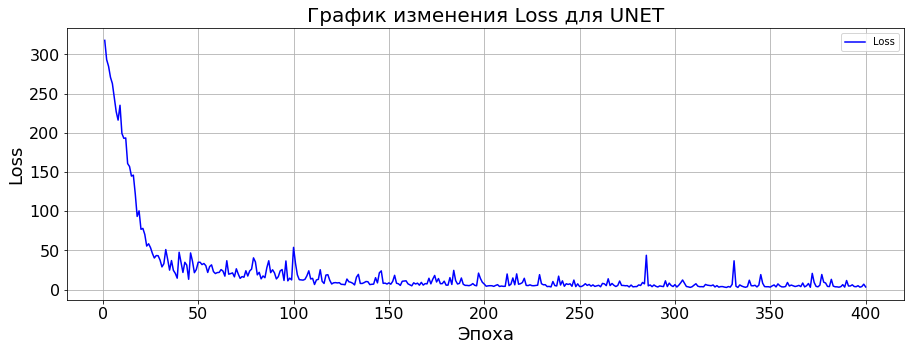

In [30]:
plot_loss("log_loss_UNET_400", 0)

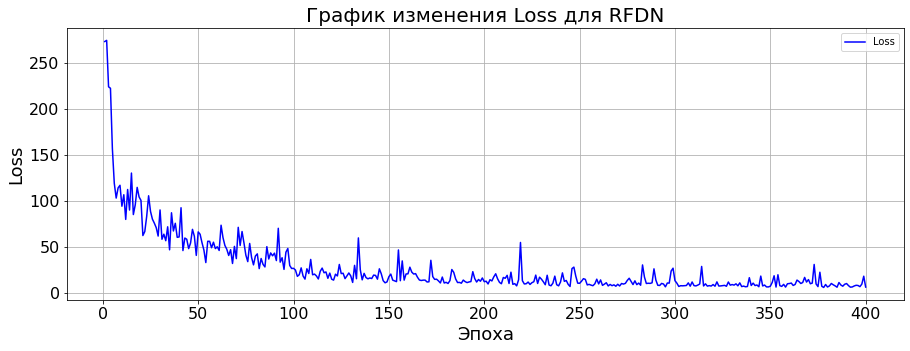

In [31]:
plot_loss("log_loss_RFDN_400",1)

Функция для вывода результатов

In [14]:
def compare_models(model_RFDN, model_Unet, train_data_loader):
    # Создаем фигуру с 2 строками (по одной на модель) и 3 столбцами
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
    
    # Получаем данные
    input_, output_ = next(iter(train_data_loader))
    
    
    #pred = train.model(input_.to(train.device))
    #pred = pred.detach().cpu().numpy()
    # Первая модель
    
    pred1 = model_RFDN.model(input_.to(model_RFDN.device))
    pred1 = pred1.detach().cpu().numpy()
    
    # Вторая модель
    pred2 = model_Unet.model(input_.to(model_Unet.device))
    pred2 = pred2.detach().cpu().numpy()
    
    col_titles = ["Входные данные", "", "Генератор"]
    
    # Заполняем первую строку (модель 1)
    for col in range(3):
        if col == 0:
            img = input_[0,0].squeeze()
        elif col == 1:
            img = pred1[0,0].squeeze()
        else:
            img = output_[0,0].squeeze()
        
        axes[0, col].imshow(img)
        axes[0, col].axis("off")
        if col == 1:
            axes[0, col].set_title(col_titles[col] + "RFDN", pad=10)
        else:
            axes[0, col].set_title(col_titles[col], pad=10)
    
    # Заполняем вторую строку (модель 2)
    for col in range(3):
        if col == 0:
            img = input_[0,0].squeeze()
        elif col == 1:
            img = pred2[0,0].squeeze()
        else:
            img = output_[0,0].squeeze()
        
        axes[1, col].imshow(img)
        axes[1, col].axis("off")
        if col == 1:
            axes[1, col].set_title(col_titles[col] + "UNET", pad=10)
        else:
            axes[1, col].set_title(col_titles[col], pad=10)
    
    # Общий заголовок
    plt.suptitle("Визуализация результатов", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

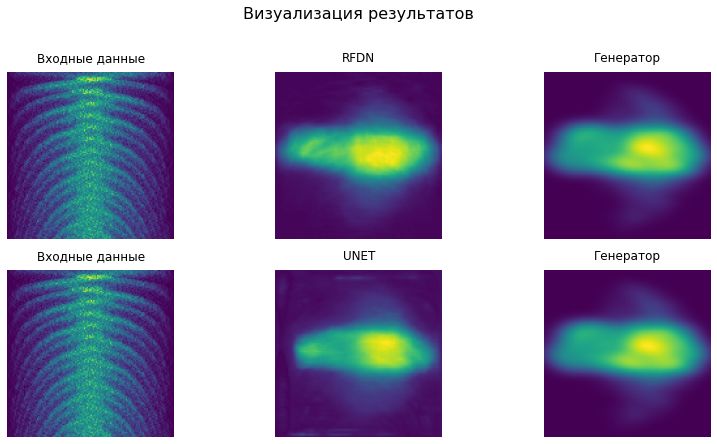

In [15]:
compare_models(train, train_U, train_data_loader)

Метрики для оценки работы модели 

In [ ]:
import torch
import numpy as np
from scipy.stats import pearsonr
from skimage.metrics import structural_similarity as ssim
from math import log10

# Считаем для 100 пар данных
num_samples = 100

# Массивы для всех предсказанных и истинных значений
pred_all_U = []
pred_all_R = []
output_all = []

# Для накопления метрик по всем изображениям
total_psnr_U = 0
total_ssim_U = 0
total_psnr_R = 0
total_ssim_R = 0

for i in range(num_samples):
    input_, output_ = next(iter(train_data_loader))  
    with torch.no_grad():
        pred_U = train_U.model(input_.to(train.device)).detach().cpu()
        pred_R = train.model(input_.to(train.device)).detach().cpu()
    # Удаляем размерности: (1, 1, 128, 128) → (128, 128)
    pred_U_np = pred_U.squeeze().numpy()
    pred_R_np = pred_R.squeeze().numpy()
    output_np = output_.squeeze().cpu().numpy()

    # Добавляем все предсказания и все истинные изображения в список
    pred_all_U.append(pred_U_np.flatten())  # Преобразуем в одномерный массив
    pred_all_R.append(pred_R_np.flatten())
    output_all.append(output_np.flatten())  # Преобразуем в одномерный массив

    # MSE для PSNR
    max_image_U = pred_U_np.max()
    #print(max_image_U)
    mse_U = np.mean((pred_U_np - output_np) ** 2)
    psnr_U = 10 * log10(max_image_U**2 / mse_U) if mse_U != 0 else float('inf')
    total_psnr_U += psnr_U  # Накопление PSNR

    # SSIM
    ssim_val_U = ssim(pred_U_np, output_np, data_range=1.0)
    total_ssim_U += ssim_val_U  # Накопление SSIM
    #RFDN

    # MSE для PSNR
    max_image_R = pred_R_np.max()
    #print(max_image_R)
    mse_R = np.mean((pred_R_np - output_np) ** 2)
    psnr_R = 10 * log10(max_image_R**2 / mse_R) if mse_R != 0 else float('inf')
   # psnr_R = 10 * log10(1 / mse_R) if mse_R != 0 else float('inf')
    total_psnr_R += psnr_R  # Накопление PSNR

    # SSIM
    ssim_val_R = ssim(pred_R_np, output_np, data_range=1.0)
    total_ssim_R += ssim_val_R  # Накопление SSIM
    #print(i, end ='\n')

# Преобразуем списки в одномерные массивы для расчета Пирсона
pred_all_U_np = np.concatenate(pred_all_U)

# Преобразуем списки в одномерные массивы для расчета Пирсона
pred_all_R_np = np.concatenate(pred_all_R)

output_all_np = np.concatenate(output_all)

# Корреляция Пирсона для всех 1000 изображений
pearson_corr_U, _ = pearsonr(pred_all_U_np, output_all_np)

pearson_corr_R, _ = pearsonr(pred_all_R_np, output_all_np)
# Средние значения PSNR и SSIM
avg_psnr_R = total_psnr_R / num_samples
avg_ssim_R = total_ssim_R / num_samples
avg_psnr_U = total_psnr_U / num_samples
avg_ssim_U = total_ssim_U / num_samples
print("RFDN")
print(f"Средний PSNR для 100 изображений: {avg_psnr_R:.2f} dB")
print(f"Средний SSIM для 100 изображений: {avg_ssim_R:.4f}")
print(f"Корреляция Пирсона для всех 100 изображений: {pearson_corr_R:.4f}")
print("UNET")
print(f"Средний PSNR для 100 изображений: {avg_psnr_U:.2f} dB")
print(f"Средний SSIM для 100 изображений: {avg_ssim_U:.4f}")
print(f"Корреляция Пирсона для всех 100 изображений: {pearson_corr_U:.4f}")

In [71]:
from math import log10

input_, output_ = next(iter(train_data_loader))

pred = train_U.model(input_.to(train.device)).detach().cpu()

# Удаляем размерности: (1, 1, 128, 128) → (128, 128)
pred_np = pred.squeeze().numpy()
output_np = output_.squeeze().cpu().numpy()

# MSE с использованием torch
mse = F.mse_loss(pred, output_).item()

# PSNR
psnr = 10 * log10(1 / mse) if mse != 0 else float('inf')

# SSIM — data_range=1.0, если значения в [0,1]
# нормировать на 1 prend_np = pred_np -pred_np.min() 
#prend_np = pred_np /pred_np.max() 
ssim_val = ssim(pred_np, output_np, data_range=1.0)

print(f"MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

MSE: 46.201172, PSNR: -16.65 dB, SSIM: 0.4444


In [68]:
from math import log10



pred = train.model(input_.to(train.device)).detach().cpu()

# Удаляем размерности: (1, 1, 128, 128) → (128, 128)
pred_np = pred.squeeze().numpy()
output_np = output_.squeeze().cpu().numpy()

# MSE с использованием torch
mse = F.mse_loss(pred, output_).item()

# PSNR
psnr = 10 * log10(1 / mse) if mse != 0 else float('inf')

# SSIM — data_range=1.0, если значения в [0,1]
ssim_val = ssim(pred_np, output_np, data_range=1.0)

print(f"MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

MSE: 1.326227, PSNR: -1.23 dB, SSIM: 0.6685
